# Ray theoretical travel times and paths

---
## What we learn in this note book
Here we demonstrate the use of `taup` to demonstrate the propagation of seismic wave in high-frequency ray theory approximation:
- Predict travel time of a seismic phase given source depth and epicentral distance.
- Plot the ray path in a 1D spherical Earth model.

Note: The content of this notebook follows closely the [documentation](https://docs.obspy.org/packages/obspy.taup.html#basic-usage) of the `obspy.taup` package.

--- 
## Conversion between distances in kms and degrees

It is convenient in passive seismology to work with distances in degrees. The nominal radius of the Earth is $R = 6371$ km. One degree along the Earth's circumference is $\dfrac{2 \pi \times R}{360} \approx 111.195$ km/$^\circ$.

In [122]:
import numpy as np
import matplotlib.pyplot as plt

R = 6371
C = 2 * 3.14159265359 * R
KMPERDEG = C / 360
print(f"Distance in kms = distance in degrees times {np.round(KMPERDEG, 3)} (km/deg).")

Distance in kms = distance in degrees times 111.195 (km/deg).


---
## Travel Times

[`get_travel_time()`](https://docs.obspy.org/packages/autogen/obspy.taup.tau.TauPyModel.get_travel_times.html#obspy.taup.tau.TauPyModel.get_travel_times) method predict the travel time of a chosen seismic phase from a source at depth in km over a distance in degree.


In [123]:
# Import obspy.taup and initialize a taup model
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91") # iasp91 is the default model, which can be changed to ak135 or prem

# Output of get_travel_times() method is a list of seismic arrivals
arrivals = model.get_travel_times(source_depth_in_km=10, distance_in_degree=30)
print(arrivals) # Print the list of seismic arrivals

35 arrivals
	P phase arrival at 368.735 seconds
	pP phase arrival at 371.793 seconds
	sP phase arrival at 373.132 seconds
	PP phase arrival at 425.245 seconds
	PP phase arrival at 425.281 seconds
	PP phase arrival at 425.604 seconds
	PP phase arrival at 436.405 seconds
	PP phase arrival at 436.522 seconds
	PcP phase arrival at 550.512 seconds
	S phase arrival at 667.645 seconds
	pS phase arrival at 671.257 seconds
	sS phase arrival at 672.887 seconds
	SP phase arrival at 673.390 seconds
	PS phase arrival at 675.022 seconds
	SP phase arrival at 691.586 seconds
	SP phase arrival at 691.625 seconds
	PS phase arrival at 693.925 seconds
	PS phase arrival at 693.932 seconds
	SS phase arrival at 760.654 seconds
	ScP phase arrival at 772.722 seconds
	PcS phase arrival at 773.985 seconds
	SS phase arrival at 795.729 seconds
	SS phase arrival at 795.816 seconds
	PKiKP phase arrival at 1002.812 seconds
	pPKiKP phase arrival at 1006.258 seconds
	sPKiKP phase arrival at 1007.511 seconds
	ScS phase 

If the input parameters do not specify seismic phases, all possible arrivals at 30° epicentral distances will be calculated and returned. One can use `phase_list` parameter to specify the [seismic phase](https://docs.obspy.org/packages/obspy.taup.html#phase-naming-in-obspy-taup) of interest.

In [124]:
arrivals = model.get_ray_paths(source_depth_in_km=10, distance_in_degree=30, phase_list=["P", "S"])
print (arrivals)

2 arrivals
	P phase arrival at 368.734 seconds
	S phase arrival at 667.645 seconds


The method returns one arrival each for P and S waves from a source at 10 km depth and 30° epicentral distance. Let inspect the arrivals and plot more information!

In [125]:
for arrival in arrivals:
    print ("_________________________")
    print (f"Phase name: {arrival.name}")
    print (f"Arrival time: {arrival.time:.2f} seconds")
    print (f"Distance: {arrival.distance}°")
    print (f"Take-off angle: {arrival.takeoff_angle:.2f}°")
    print (f"Ray parameter: {arrival.ray_param:.2f} (s/rad) = {arrival.ray_param/R:.2f} (s/km)")

_________________________
Phase name: P
Arrival time: 368.73 seconds
Distance: 30°
Take-off angle: 27.52°
Ray parameter: 506.76 (s/rad) = 0.08 (s/km)
_________________________
Phase name: S
Arrival time: 667.64 seconds
Distance: 30°
Take-off angle: 28.31°
Ray parameter: 897.68 (s/rad) = 0.14 (s/km)


The ray parameter, defined as $\dfrac{\sin i}{v}$, is constant along the ray path according to the Fermat's principle. Because the ray parameter is inversely propotional to speed, it is also refered as *slowness*. The take-off angle, as its name suggested, is the angle of the ray path when it leaves the source. 

---
## Ray Paths
We can also calulate the path of a seismic ray propagating in a spherical Earth model using `get_ray_paths()`. The following cell calculates the ray paths of seismic arrivals from a seismic source placed at 10 km depth to a receiver at 30° epicentral distance.

In [126]:
arrivals = model.get_ray_paths(source_depth_in_km=10, distance_in_degree=30, 
                               # ttbasic is not a standard phase name, but refers to a group of basic phases
                               phase_list=["ttbasic"]) 
print (arrivals[0].path.dtype)

[('p', '<f8'), ('time', '<f8'), ('dist', '<f8'), ('depth', '<f8')]


Now, the ray path for each arrival is stored in `path` field. This field is a list of tuples each constains the unique ray parameter `p`, travel time `time`, distance `dist`, and depth `depth` of each calculation nodes along the ray path.

Use function `arrivals.plot_rays()` to see the ray paths in a cross section of the Earth.

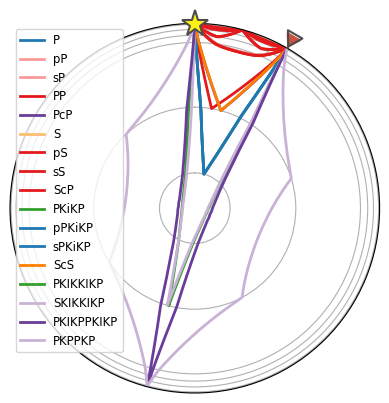

In [127]:
arrivals.plot_rays(plot_type="spherical", legend=True)
plt.show()

The ray paths also be plotted in a flatten Earth when `plot_type` is set to `catersian`.

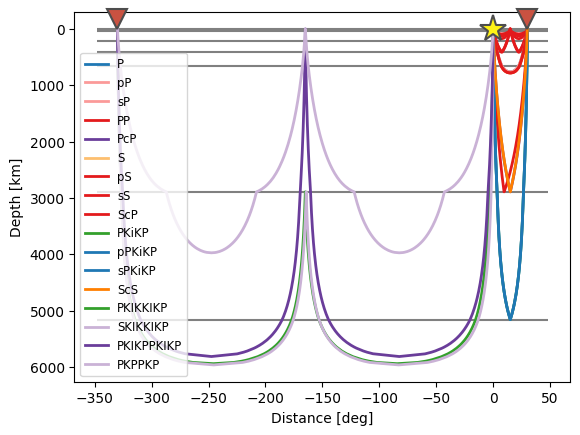

In [128]:
arrivals.plot_rays(plot_type="cartesian", legend=True)
plt.show()

---
## Travel Time Curves

The ray path of a seismic phase from source to receiver is deteministic in an Earth model and is function of epicentral distance and source depth. Given a source depth, a travel time curve represents the variation of travel time as a function of epicentral distances.

Let's consider the travel of P waves from a source on the Earth surface, i.e., depth = 0 km, to an arrange of seismic array equally distributed from 10 to 50 degrees.

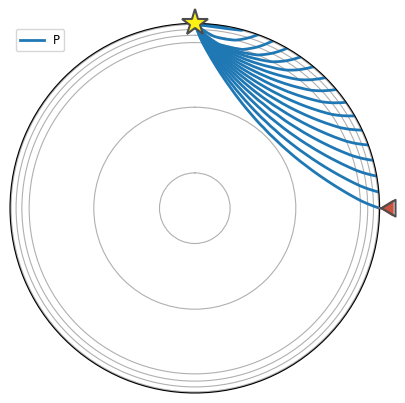

In [129]:
from obspy.taup.tau import Arrivals
list_of_distances = np.arange(0, 91, 5)
list_of_arrivals = []
for dist in list_of_distances:
    arrivals = model.get_ray_paths(source_depth_in_km=0, distance_in_degree=dist, phase_list=["P"])
    list_of_arrivals.append(arrivals[0]) # append arrivals to list for every 5 degrees
arrivals = Arrivals(list_of_arrivals, model.model) # create an Arrivals object
arrivals.plot_rays(plot_type="spherical", legend=True)
plt.show()

And, the travel time curve is

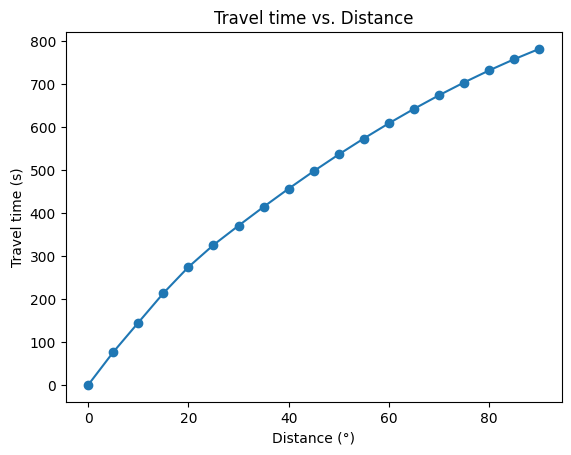

In [130]:
list_of_ttimes = []
for arrivals in list_of_arrivals:
    list_of_ttimes.append(arrivals.time)
plt.plot(list_of_distances, list_of_ttimes, "o-")
plt.xlabel("Distance (°)")
plt.ylabel("Travel time (s)")
plt.title("Travel time vs. Distance")
plt.show()

Note that, the P-wave's travel time curve above has been calculated at a discrete collection of epicentral distances and the calculation time is propotional to the desired number of distances. To avoid additonal calculation, the calculated points can be interpolated in 1D to reduce actual calculation without much degradation in accuracy.

In [131]:
# Interpolated function for travel time vs. distance
P_time = 50
dist = np.interp(P_time, list_of_ttimes, list_of_distances)
# What's the epicentral distance if P-wave takes 50 seconds to travel from source to receiver?
print (f"Distance for {P_time} seconds: {dist:.2f}° or {dist*KMPERDEG:.2f} km")

Distance for 50 seconds: 3.28° or 364.46 km


Have you notice that the slop of the travel time curve as unit of `s/°`, which coincides with the unit of ray parameter, also know as slowness?! Indeed, the slope of the travel time curve at a given distance is the ray parameter of its travel ray path. This proof can be found in any seismological textbook, but beyond the scope of this introductory workshop.

---
## Challenge

Let's try what you have learned!

In the example above, you are determined to determine the epicentral distance given a measured P-wave travel time. Now we look at how we can calculate the distance given the measured difference between S and P-wave arrivals.  To complete this excercise, please copy the following code blocks to a new Python cell, replace all <YOUR CODE> instances with your codes.

Good luck!

```
# Add your name to show in the plot title
your_name = <YOUR CODE>

# Calculate travel times for P and S waves for distances from 0 to 20 degrees
distances = np.arange(21)
P_times = [] # List to store P-wave travel times
S_times = [] # List to store S-wave travel times
for dist in distances:
    # Calculate and save P-wave travel time
    arrivals = <YOUR CODE>
    P_times.append(arrivals[0].time)
    # Calculate and save S-wave travel time
    arrivals = model.get_travel_times(0, dist, ["S"])
    S_times.<YOUR CODE>

# Convert lists to numpy arrays for easy manipulation
P_times = np.array(P_times)
S_times = np.array(S_times)

# Use numpy.interp() to interpolate distance for a given differential travel time (ΔT)
dtime = 100
dist = np.interp(dtime, S_times-P_times, distances)

# Calculate P and S wave travel times for the interploated distance
P_time = <YOUR CODE>
S_time = <YOUR CODE>

# Plot the results
fig, ax = plt.subplots()
ax.plot(distances, S_times, "-", label="S-wave")
ax.plot(distances, P_times, "-", label="P-wave")
ax.axvline(x=dist, color="black", linestyle="--", lw=0.75)
ax.annotate("", xy=(dist, S_time), xytext=(dist, P_time), arrowprops=dict(arrowstyle="<|-|>"))
ax.text(dist+.2, (P_time+S_time)/2, f"ΔT = {dtime:.0f} s")
ax.set(xlabel="Distance (°)", ylabel="Travel time (s)", title=f"Travel time curve by {your_name}")
ax.text(dist+.2, 0, f"D = {dist:.2f}°")
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()
```

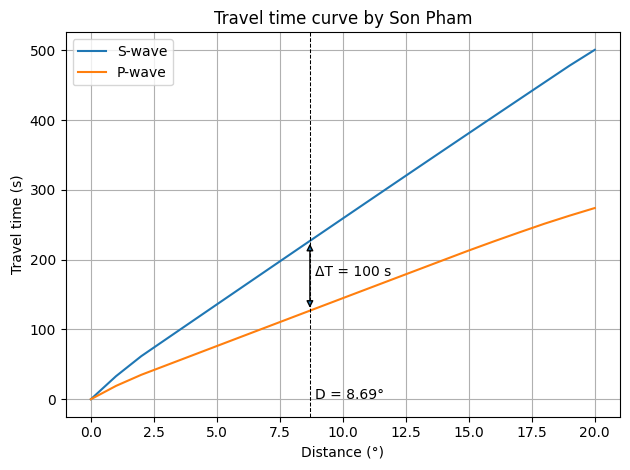

In [132]:
# Add your name to show in the plot title
your_name = "Son Pham"

# Calculate travel times for P and S waves for distances from 0 to 20 degrees
distances = np.arange(21)
P_times = [] # List to store P-wave travel times
S_times = [] # List to store S-wave travel times
for dist in distances:
    # Calculate and save P-wave travel time
    arrivals = model.get_travel_times(0, dist, ["P"])
    P_times.append(arrivals[0].time)
    # Calculate and save S-wave travel time
    arrivals = model.get_travel_times(0, dist, ["S"])
    S_times.append(arrivals[0].time)

# Convert lists to numpy arrays for easy manipulation
P_times = np.array(P_times)
S_times = np.array(S_times)

# Use numpy.interp() to interpolate distance for a given differential travel time (ΔT)
dtime = 100
dist = np.interp(dtime, S_times-P_times, distances)

# Calculate P and S wave travel times for the interploated distance
P_time = np.interp(dist, distances, P_times)
S_time = np.interp(dist, distances, S_times)

# Plot the results
fig, ax = plt.subplots()
ax.plot(distances, S_times, "-", label="S-wave")
ax.plot(distances, P_times, "-", label="P-wave")
ax.axvline(x=dist, color="black", linestyle="--", lw=0.75)
ax.annotate("", xy=(dist, S_time), xytext=(dist, P_time), arrowprops=dict(arrowstyle="<|-|>"))
ax.text(dist+.2, (P_time+S_time)/2, f"ΔT = {dtime:.0f} s")
ax.set(xlabel="Distance (°)", ylabel="Travel time (s)", title=f"Travel time curve by {your_name}")
ax.text(dist+.2, 0, f"D = {dist:.2f}°")
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()